# Analyse pandas files

Purpose detection of bad files

work with Weakly_2023_11
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/04/04
- last update : 2023/04/07


In [1]:
import h5py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

In [3]:
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})
#sns.set(rc={'figure.figsize':(16,16)})

In [4]:
import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from astropy.time import Time
import astropy.units as u

In [6]:
DateToRuncollection = {
    
    
 # september 2022
 20220912 :  "u/dagoret/BPS_manyspectro_v60", # Missing collection
 20220913 :  "u/dagoret/BPS_manyspectro_v61", # Missing collection
 20220914 :  "u/dagoret/BPS_manyspectro_v62", # Missing collection  
    
 20220927 :  "u/dagoret/BPS_manyspectro_v63", # Mount errors available, mitigé
 20220928 :  "u/dagoret/BPS_manyspectro_v64", # Mount errors available, very nice spectra
 20220929 :  "u/dagoret/BPS_manyspectro_v65", # Mount errors available, very nice spectra
    
    
 # october 2022
 20221012 :  "u/dagoret/BPS_manyspectro_v56", # mount errors , nice, all good
 20221025 :  "u/dagoret/BPS_manyspectro_v57", # mount errors, very very bad spectra, run not selected
 20221026 :  "u/dagoret/BPS_manyspectro_v58", # mount errors,  very nice spectra, all good
 20221027 :  "u/dagoret/BPS_manyspectro_v59", # mount errors,  nice spectra, all good
    
 # november 2022
 20221109 :  "u/dagoret/BPS_manyspectro_v53", # mount errors, nice spectra, few bad labelled as good 
 20221110 :  "u/dagoret/BPS_manyspectro_v54", # mount errors available, many bad rec spectra, few bad labelled as good, versy strange
 20221123 :  "u/dagoret/BPS_manyspectro_v55", # mount errors , nice   
    
 # december 2022   
 20221207 :  "u/dagoret/BPS_manyspectro_v48", # No mount error, nice spectra
 20221208 :  "u/dagoret/BPS_manyspectro_v49", # No mount error, nice spectra, one bad labelled as good
 20221209 :  "u/dagoret/BPS_manyspectro_v50", # No mount error, spectra at distance from optical center, very interesting
 20221210 :  "u/dagoret/BPS_manyspectro_v51", # No mount error, bof
 20221212 :  "u/dagoret/BPS_manyspectro_v52", # No mount error, very bad gains and instability 
    
 #January 2023 
 20230117 :  "u/dagoret/BPS_manyspectro_v79", # no mount errors, some mucol spectra that looks good are rejected on DCCD
 20230118 :  "u/dagoret/BPS_manyspectro_v80", # no mount error, some mucol looking good are rejected, many bad centroid calculation
 20230119 :  "u/dagoret/BPS_manyspectro_v77", # no mount errors, many blurred spectra probably due to strong tracking error
 20230131 :  "u/dagoret/BPS_manyspectro_v78", # missing for moment

 #february 2023
 20230214 :  "u/dagoret/BPS_manyspectro_v42", # no mount errors, nothing special
 20230215 :  "u/dagoret/BPS_manyspectro_v43", # mount errors, OK
 20230216 :  "u/dagoret/BPS_manyspectro_v44", # mount errors, OK, nice spectra 
 20230228 :  "u/dagoret/BPS_manyspectro_v70", # No mount error,OK nice spectra
    
 #march 2023  
 20230301 :  "u/dagoret/BPS_manyspectro_v71", # no mount errors, OK many spectra
 20230302 :  "u/dagoret/BPS_manyspectro_v72", # no mount error, sometime bad subtraction of order2 on HD38666 (mucol) 
 20230315 :  "u/dagoret/BPS_manyspectro_v73", # mount errors
 20230316 :  "u/dagoret/BPS_manyspectro_v74", # mount errors   
    
    
}

In [7]:
DATE = 20220928
filterdispersername = "empty~holo4_003"

In [8]:
configmode = "PSF2DFFM_REBIN2"
specver="specV2.4"

In [9]:
input_summary_file = f"fullsummaryspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.csv"
input_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.hdf5"

In [10]:
input_summary_file

'fullsummaryspectra_20220928-empty~holo4_003-PSF2DFFM_REBIN2-specV2.4-oga.csv'

In [11]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 189
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

xtarget_min = 50
xtarget_max = 250

ytarget_min = 700
ytarget_max = 1000

In [12]:
def SelectionCriteria(row):
    """
    Calculate the Spectrum selection flag on pandas dataframe
    
    call it on a dataframe df as
    
    flag_selection = df[["spec_header_d2ccd","spec_header_targetx","spec_header_targety"]].apply(SelectionCriteria,axis=1)
    """
    

    d2ccd = row["spec_header_d2ccd"]
    xtarget = row["spec_header_targetx"]
    ytarget = row["spec_header_targety"]
    
    flag_selection_d2ccd = (d2ccd > d2ccd_min)  and (d2ccd < d2ccd_max) 
    flag_selection_target = (xtarget > xtarget_min)  and (xtarget < xtarget_max ) and (ytarget > ytarget_min)  and (ytarget < ytarget_max )
    flag_selection = flag_selection_d2ccd and flag_selection_target
    return flag_selection

# Read pandas file

In [13]:
df=pd.read_csv(input_summary_file,index_col=0)

In [14]:
df

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,me_az_rms,me_el_rms,me_rot_rms,me_image_az_rms,me_image_el_rms,me_image_rot_rms
0,0,2022092800358,2022-09-29T02:07:48.026501837Z,HD185975,empty,1.844346,0,0,0,-339.105629,21.448126,159.406447,1,HD185975,-0.000065,holo4_003,0.448105,187.415395,0.0,21.448126,172.366832,868.201714,597.257159,0.107027,0.218776,250.204992,3.878120,1.0,1.844346,5.831303,2.4,2,2022-09-29T02:07:48.026501837Z,30.0,1.844346,-87.489967,-339.105629,0,0,0,empty,159.406447,-417.028866,84.201714,589,1726,784,969,1137,185,2,22666.666667,-417.028866,84.201714,589,1726,784,969,2,22666.666667,1137,185,0.035163,0.017103,0.094973,0.029573,0.017103,0.000129
1,1,2022092800359,2022-09-29T02:08:31.036003572Z,HD185975,empty,1.844478,0,0,0,-338.925900,21.632361,159.406515,1,HD185975,-0.000065,holo4_003,0.457919,187.314831,0.0,21.632361,173.376301,867.028459,597.257159,0.100093,0.346487,241.805723,4.690418,1.0,1.844478,5.944990,2.4,2,2022-09-29T02:08:31.036003572Z,30.0,1.844478,-87.489974,-338.925900,0,0,0,empty,159.406515,-418.496708,84.028459,592,1728,783,968,1136,185,2,22666.666667,-418.496708,84.028459,592,1728,783,968,2,22666.666667,1136,185,0.030417,0.013140,0.108040,0.025582,0.013140,0.000147
2,2,2022092800369,2022-09-29T02:15:09.018003809Z,HD167060,empty,1.481583,0,0,0,-303.866248,75.491970,105.742479,1,HD167060,0.000051,holo4_003,0.358179,187.411464,0.0,75.491970,154.472226,866.301872,590.272636,0.087189,0.296568,244.982223,2.614734,1.0,1.481583,5.765854,2.4,2,2022-09-29T02:15:09.018003809Z,30.0,1.481583,-61.746734,-303.866248,0,0,0,empty,105.742479,-417.834023,86.301872,572,1709,780,965,1137,185,2,22666.666667,-417.834023,86.301872,572,1709,780,965,2,22666.666667,1137,185,0.011561,0.027700,0.142765,0.008538,0.027700,0.000194
3,3,2022092800370,2022-09-29T02:15:52.013493321Z,HD167060,empty,1.483908,0,0,0,-303.686608,75.669373,105.742470,1,HD167060,0.000051,holo4_003,0.361795,187.503375,0.0,75.669373,152.679709,866.683219,590.272636,-0.041364,0.272859,257.869130,2.674937,1.0,1.483908,5.035807,2.4,2,2022-09-29T02:15:52.013493321Z,30.0,1.483908,-61.746734,-303.686608,0,0,0,empty,105.742470,-417.296844,85.683219,571,1708,781,966,1137,185,2,22666.666667,-417.296844,85.683219,571,1708,781,966,2,22666.666667,1137,185,0.016153,0.024107,0.155048,0.011944,0.024107,0.000210
4,4,2022092800380,2022-09-29T02:22:29.705999450Z,HD200654,empty,1.084765,0,0,0,-344.265282,36.805605,145.653438,1,HD200654,-0.000149,holo4_003,0.235632,187.414877,0.0,36.805605,159.428052,863.242277,596.126479,0.069301,0.468072,214.965332,2.421499,1.0,1.084765,5.899934,2.4,2,2022-09-29T02:22:29.705999450Z,30.0,1.084765,-49.992900,-344.265282,0,0,0,empty,145.653438,-417.730337,89.242277,577,1714,774,959,1137,185,2,22666.666667,-417.730337,89.242277,577,1714,774,959,2,22666.666667,1137,185,0.084598,0.024392,0.272657,0.032809,0.024392,0.000370
...,...,...,...,...,...,...

In [15]:
d2ccd_median = df["spec_header_d2ccd"].median()
df["d2ccd_shift"] = df["spec_header_d2ccd"]-d2ccd_median

# Cut

In [16]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 188
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

In [17]:
cut1 = (df['spec_header_chi2_fit'] >= chi2_fit_min ) & (df['spec_header_chi2_fit'] <= chi2_fit_max )
cut2 = (df['spec_header_d2ccd'] >= d2ccd_min ) & (df['spec_header_d2ccd'] < d2ccd_max )
cut3 = (df['spec_header_pixshift'] >= pixshift_min ) & (df['spec_header_pixshift'] < pixshift_max )

# Control plots

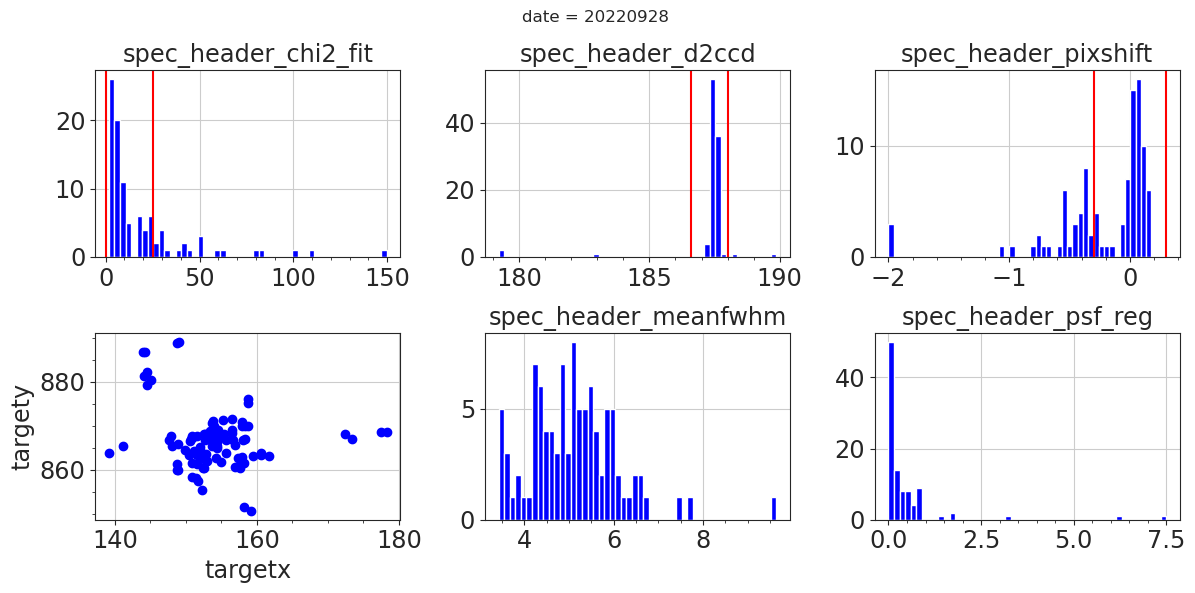

In [18]:
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(2,3)
all_names = ['spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift','None','spec_header_meanfwhm','spec_header_psf_reg']
all_minval = [chi2_fit_min, d2ccd_min, pixshift_min ]
all_maxval = [chi2_fit_max, d2ccd_max, pixshift_max ]

for i, ax in enumerate(axes.flat):    

    if i <=2 or i>3: 
        name = all_names[i]
        nbins=50
        values = df[name].values
        ax.hist(values,bins=nbins,facecolor="blue")
        ax.set_title(name)
        #ax.grid()
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        
        if i<3:
            ax.axvline(all_minval[i],color="r")
            ax.axvline(all_maxval[i],color="r")
        
    if i == 3:
        xval=df["spec_header_targetx"].values
        yval=df["spec_header_targety"].values
        ax.scatter(xval,yval,color="blue")
        ax.set_xlabel("targetx")
        ax.set_ylabel("targety")
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        #ax.grid()
plt.suptitle(f"date = {DATE}")
plt.tight_layout()
plt.show()    

In [19]:
df_cut1 = df[['spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift']]
df_cut2 = df[['spec_header_targetx','spec_header_targety']]

<Figure size 1400x1400 with 0 Axes>

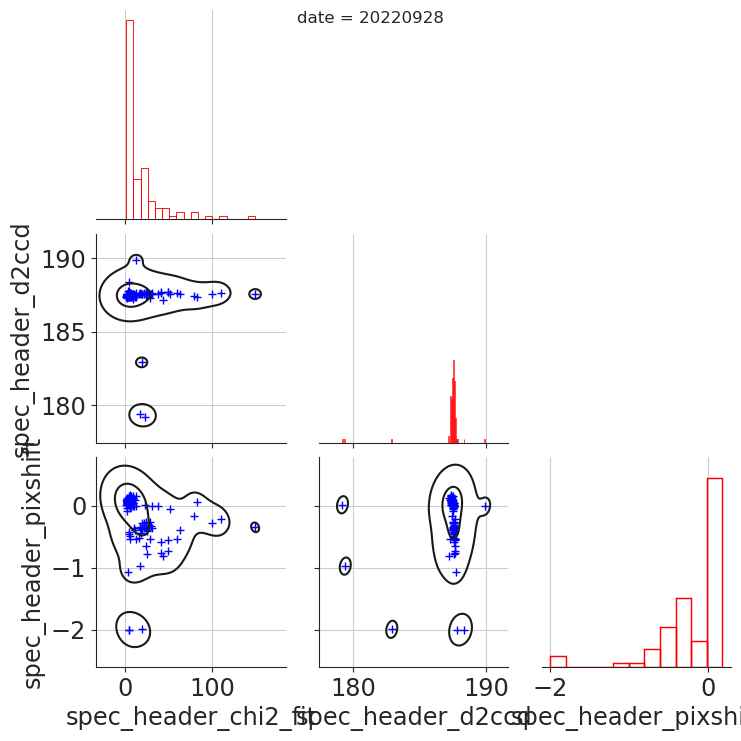

In [20]:
plt.figure(figsize=(14,14))
title = f"date = {DATE}"
g=sns.pairplot(df_cut1,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
g.map_lower(sns.kdeplot, levels=3, color=".1")
plt.suptitle(title)
plt.show()

<Figure size 1600x1600 with 0 Axes>

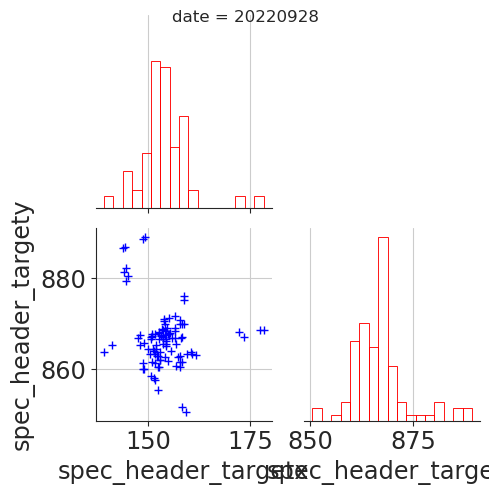

In [21]:
plt.figure(figsize=(16,16))
sns.pairplot(df_cut2,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
plt.tight_layout()
plt.suptitle(title)
plt.show()

<AxesSubplot: title={'center': 'date = 20220928 , d2ccd_median = 187.50 '}, xlabel='exposure'>

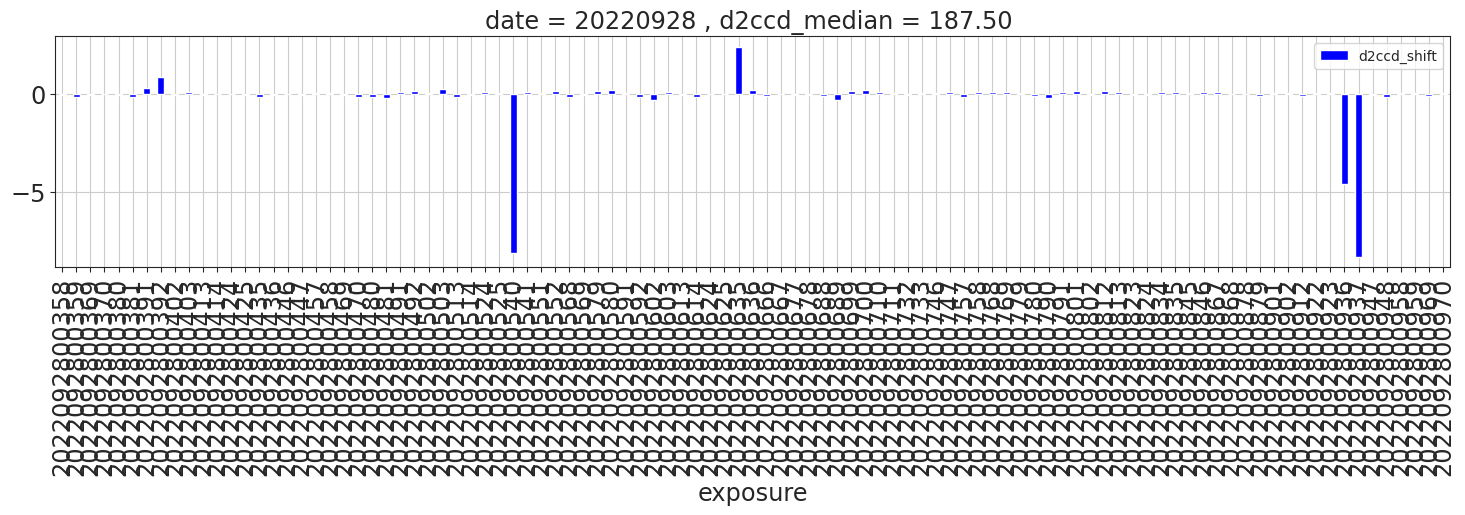

In [22]:
df.plot.bar(x="exposure", y="d2ccd_shift",color="blue",title=f"date = {DATE} , d2ccd_median = {d2ccd_median:.2f} ",figsize=(18,3))

<AxesSubplot: title={'center': 'date = 20220928, chi2_median = 8.86 '}, xlabel='exposure'>

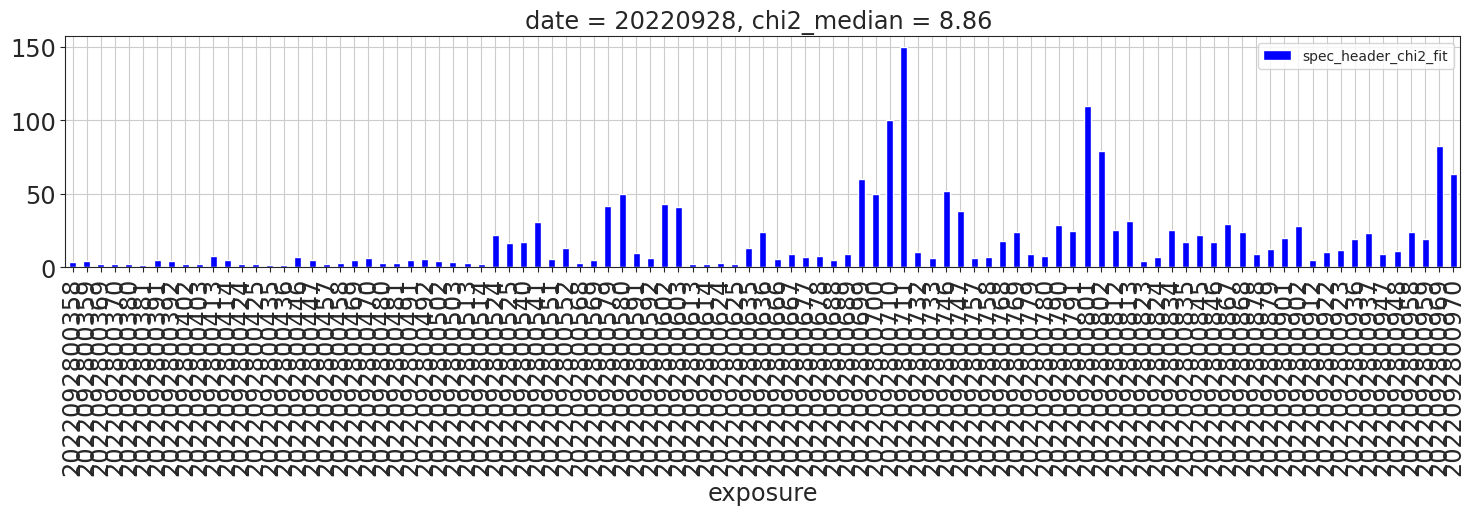

In [23]:
chi2_median = df["spec_header_chi2_fit"].median()
df.plot.bar(x="exposure", y="spec_header_chi2_fit",color="blue",title=f"date = {DATE}, chi2_median = {chi2_median:.2f} ",figsize=(18,3))

<AxesSubplot: title={'center': 'date = 20220928, pixshift_median = -0.008'}, xlabel='exposure'>

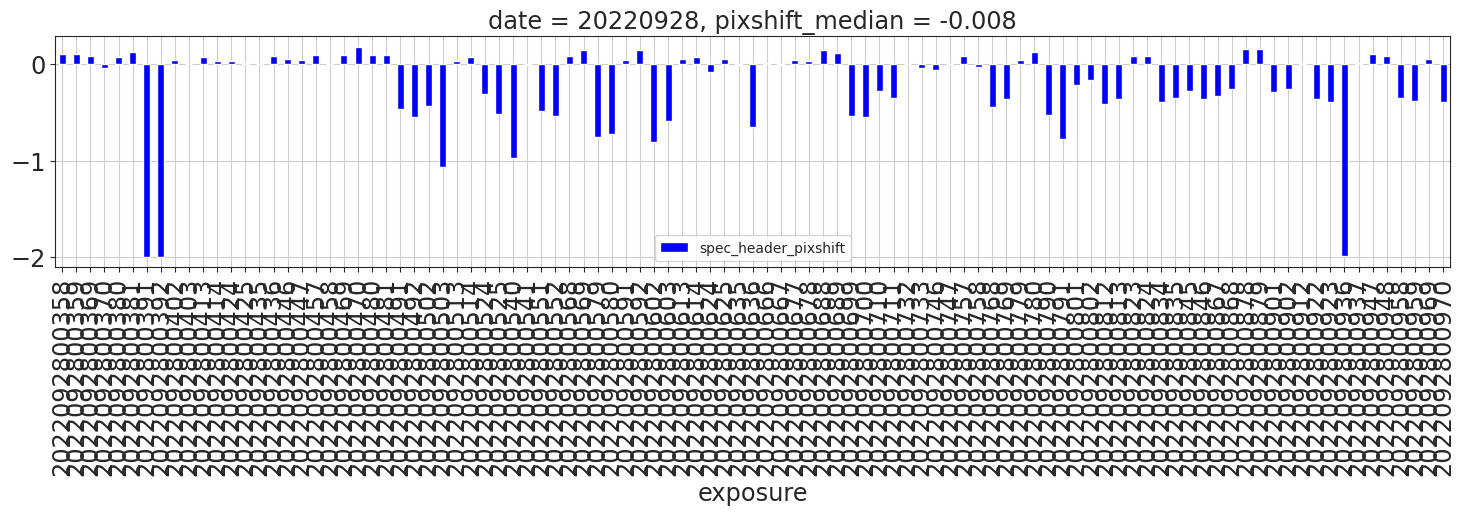

In [24]:
pixshift_median = df["spec_header_pixshift"].median()
df.plot.bar(x="exposure", y="spec_header_pixshift",color="blue", title=f"date = {DATE}, pixshift_median = {pixshift_median:.3f}",figsize=(18,3))

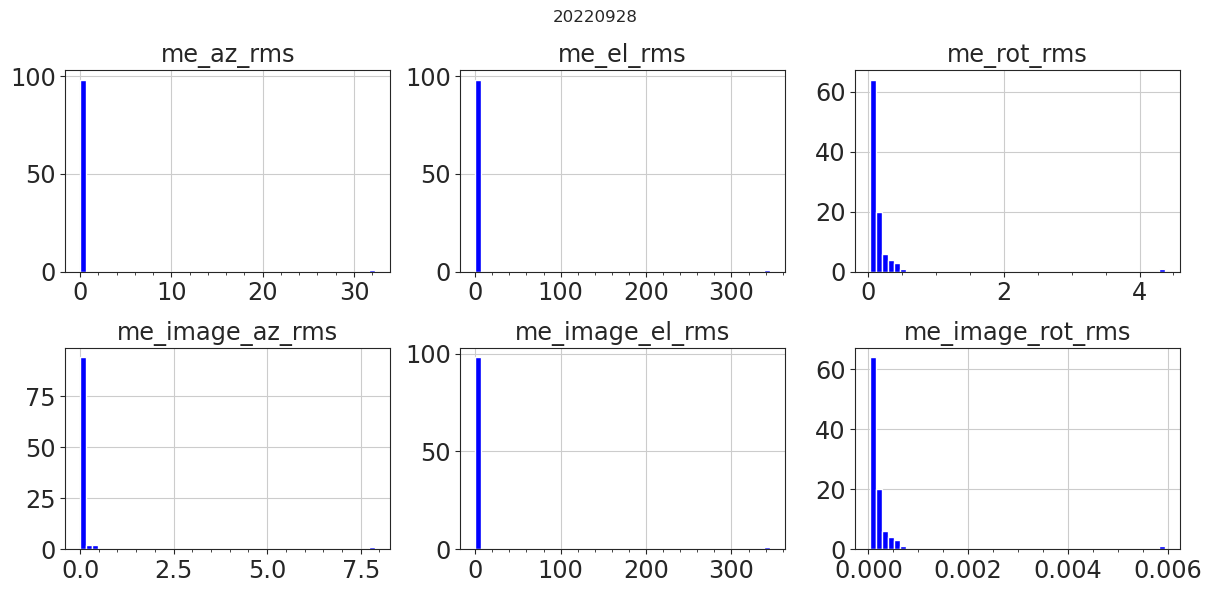

In [25]:
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(2,3)
all_names = ["me_az_rms","me_el_rms","me_rot_rms","me_image_az_rms","me_image_el_rms","me_image_rot_rms"]

for i, ax in enumerate(axes.flat):    
    name = all_names[i]
    nbins=50
    values =  df[name].values
    ax.hist(values,bins=nbins,facecolor="blue")
    ax.set_title(name)
    #ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    
plt.suptitle(DATE)
plt.tight_layout()
plt.show()    

In [26]:
df_cut3 =df[all_names]

<Figure size 1400x1400 with 0 Axes>

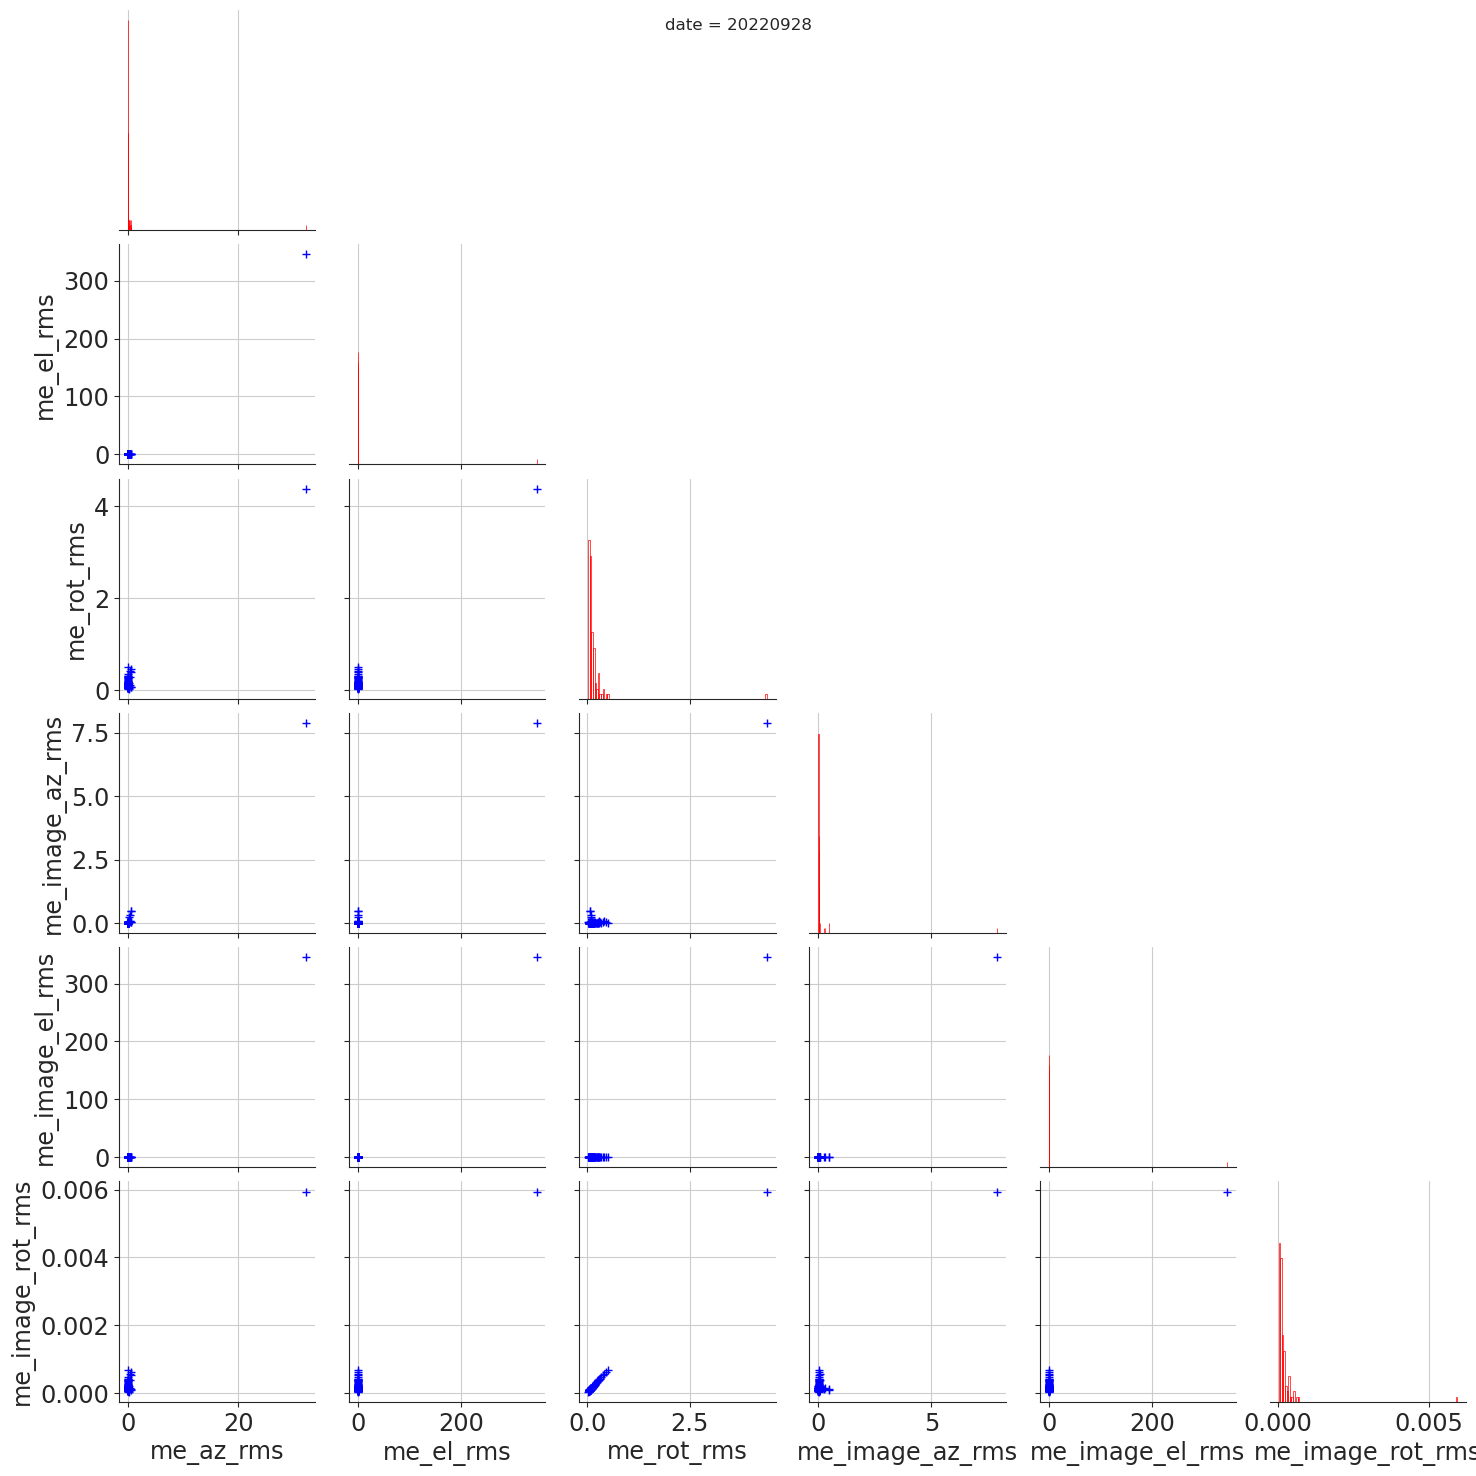

In [27]:
plt.figure(figsize=(14,14))
sns.pairplot(df_cut3,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
plt.suptitle(f"date = {DATE}")
plt.show()

# Selection of Bads and goods

In [28]:
df[~(cut1 & cut2 & cut3)]

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,me_az_rms,me_el_rms,me_rot_rms,me_image_az_rms,me_image_el_rms,me_image_rot_rms,d2ccd_shift
6,6,2022092800391,2022-09-29T02:29:46.408006505Z,HD167060,empty,1.531606,0,0,0,-300.194913,79.062731,102.121843,1,HD167060,0.000051,holo4_003,0.371906,187.789250,0.0,79.062731,150.702685,866.973455,590.272636,-1.999999,5.624223e-01,219.523954,5.340585,1.0,1.531606,6.412984,2.4,2,2022-09-29T02:29:46.408006505Z,30.0,1.531606,-61.746901,-300.194913,0,0,0,empty,102.121843,-419.000876,85.973455,573,1710,781,966,1137,185,2,22666.666667,-419.000876,85.973455,573,1710,781,966,2,22666.666667,1137,185,0.013372,0.025028,0.155054,0.010137,0.025028,0.000210,0.285875
7,7,2022092800392,2022-09-29T02:30:29.216991014Z,HD167060,empty,1.534181,0,0,0,-300.016052,79.233864,102.121899,1,HD167060,0.000051,holo4_003,0.375306,188.345903,0.0,79.233864,154.349628,866.549583,590.272636,-1.999997,8.329616e-01,218.330372,4.608989,1.0,1.534181,5.797977,2.4,2,2022-09-29T02:30:29.216991014Z,30.0,1.534181,-61.746912,-300.016052,0,0,0,empty,102.121899,-419.346248,85.549583,572,1709,781,966,1137,185,2,22666.666667,-419.346248,85.549583,572,1709,781,966,2,22666.666667,1137,185,0.010572,0.036609,0.161830,0.008024,0.036609,0.000220,0.842528
24,24,2022092800491,2022-09-29T03:41:16.189501961Z,HD2811,empty,1.052327,0,0,0,-15.700708,-48.275911,230.905618,1,HD2811,0.000000,holo4_003,0.220625,187.571237,0.0,-48.275911,153.457794,868.939349,536.555932,-0.466429,1.144030e-01,268.159369,4.834636,1.0,1.052327,5.625415,2.4,2,2022-09-29T03:41:16.189501961Z,30.0,1.052327,-43.582070,-15.700708,0,0,0,empty,230.905618,-418.883620,88.939349,574,1710,780,965,1136,185,2,22666.666667,-418.883620,88.939349,574,1710,780,965,2,22666.666667,1136,185,0.085224,0.042955,0.173749,0.026571,0.042955,0.000236,0.067861
25,25,2022092800492,2022-09-29T03:41:59.180505478Z,HD2811,empty,1.051744,0,0,0,-15.521037,-47.887651,230.905567,1,HD2811,0.000000,holo4_003,0.220674,187.632712,0.0,-47.887651,153.636910,868.679698,536.555932,-0.546912,1.227969e-01,261.443247,5.482936,1.0,1.051744,5.511676,2.4,2,2022-09-29T03:41:59.180505478Z,30.0,1.051744,-43.582076,-15.521037,0,0,0,empty,230.905567,-419.545857,88.679698,575,1711,780,965,1136,185,2,22666.666667,-419.545857,88.679698,575,1711,780,965,2,22666.666667,1136,185,0.105603,0.031813,0.155256,0.032754,0.031813,0.000211,0.129337
26,26,2022092800502,2022-09-29T03:48:14.087007546Z,HD2811,empty,1.046957,0,0,0,-13.957274,-44.351636,226.913044,1,HD2811,0.000000,holo4_003,0.224424,187.522030,0.0,-44.351636,151.602180,867.636752,536.555932,-0.433123,6.633611e-02,285.926878,4.349944,1.0,1.046957,4.886408,2.4,2,2022-09-29T03:48:14.087007546Z,30.0,1.046957,-43.584155,-13.957274,0,0,0,empty,226.913044,-417.867549,89.636752,571,1708,778,963,1137,185,2,22666.666667,-417.867549,89.636752,571,1708,778,963,2,22666.666667,1137,185,0.094464,0.028178,

In [29]:
df[(cut1 & cut2 & cut3)]

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,me_az_rms,me_el_rms,me_rot_rms,me_image_az_rms,me_image_el_rms,me_image_rot_rms,d2ccd_shift
0,0,2022092800358,2022-09-29T02:07:48.026501837Z,HD185975,empty,1.844346,0,0,0,-339.105629,21.448126,159.406447,1,HD185975,-0.000065,holo4_003,0.448105,187.415395,0.0,21.448126,172.366832,868.201714,597.257159,0.107027,0.218776,250.204992,3.878120,1.0,1.844346,5.831303,2.4,2,2022-09-29T02:07:48.026501837Z,30.0,1.844346,-87.489967,-339.105629,0,0,0,empty,159.406447,-417.028866,84.201714,589,1726,784,969,1137,185,2,22666.666667,-417.028866,84.201714,589,1726,784,969,2,22666.666667,1137,185,0.035163,0.017103,0.094973,0.029573,0.017103,0.000129,-0.087980
1,1,2022092800359,2022-09-29T02:08:31.036003572Z,HD185975,empty,1.844478,0,0,0,-338.925900,21.632361,159.406515,1,HD185975,-0.000065,holo4_003,0.457919,187.314831,0.0,21.632361,173.376301,867.028459,597.257159,0.100093,0.346487,241.805723,4.690418,1.0,1.844478,5.944990,2.4,2,2022-09-29T02:08:31.036003572Z,30.0,1.844478,-87.489974,-338.925900,0,0,0,empty,159.406515,-418.496708,84.028459,592,1728,783,968,1136,185,2,22666.666667,-418.496708,84.028459,592,1728,783,968,2,22666.666667,1136,185,0.030417,0.013140,0.108040,0.025582,0.013140,0.000147,-0.188544
2,2,2022092800369,2022-09-29T02:15:09.018003809Z,HD167060,empty,1.481583,0,0,0,-303.866248,75.491970,105.742479,1,HD167060,0.000051,holo4_003,0.358179,187.411464,0.0,75.491970,154.472226,866.301872,590.272636,0.087189,0.296568,244.982223,2.614734,1.0,1.481583,5.765854,2.4,2,2022-09-29T02:15:09.018003809Z,30.0,1.481583,-61.746734,-303.866248,0,0,0,empty,105.742479,-417.834023,86.301872,572,1709,780,965,1137,185,2,22666.666667,-417.834023,86.301872,572,1709,780,965,2,22666.666667,1137,185,0.011561,0.027700,0.142765,0.008538,0.027700,0.000194,-0.091911
3,3,2022092800370,2022-09-29T02:15:52.013493321Z,HD167060,empty,1.483908,0,0,0,-303.686608,75.669373,105.742470,1,HD167060,0.000051,holo4_003,0.361795,187.503375,0.0,75.669373,152.679709,866.683219,590.272636,-0.041364,0.272859,257.869130,2.674937,1.0,1.483908,5.035807,2.4,2,2022-09-29T02:15:52.013493321Z,30.0,1.483908,-61.746734,-303.686608,0,0,0,empty,105.742470,-417.296844,85.683219,571,1708,781,966,1137,185,2,22666.666667,-417.296844,85.683219,571,1708,781,966,2,22666.666667,1137,185,0.016153,0.024107,0.155048,0.011944,0.024107,0.000210,0.000000
4,4,2022092800380,2022-09-29T02:22:29.705999450Z,HD200654,empty,1.084765,0,0,0,-344.265282,36.805605,145.653438,1,HD200654,-0.000149,holo4_003,0.235632,187.414877,0.0,36.805605,159.428052,863.242277,596.126479,0.069301,0.468072,214.965332,2.421499,1.0,1.084765,5.899934,2.4,2,2022-09-29T02:22:29.705999450Z,30.0,1.084765,-49.992900,-344.265282,0,0,0,empty,145.653438,-417.730337,89.242277,577,1714,774,959,1137,185,2,22666.666667,-417.730337,89.242277,577,1714,774,959,2,22666.666667,1137,185,0.084598,0.024392,0.272657,0.0